<a href="https://colab.research.google.com/github/pen1064/Practice/blob/main/Copy_of_Tensorflow_GP_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [2]:
df = pd.read_csv('AirlinePassengers.csv')
df['#Passengers'] = df['#Passengers'].astype('float64')
df['Date'] = pd.to_datetime(df['Month'])
df['Year'] = df['Date'].apply(lambda z: z.year)
df['Month'] = df['Date'].apply(lambda z: z.month)
x = (df['Year']+df['Month']/12).to_numpy().reshape(-1, 1)
y = df['#Passengers'].values.reshape(len(df),1)

In [7]:
xtrain = x[:round(len(x)*0.75)]
ytrain = y[:round(len(x)*0.75)].flatten()

xtest = x[round(len(x)*0.75):]
ytest = y[round(len(x)*0.75):].flatten()

Step 0: NLL = 655919.8819375971
Step 100: NLL = 12858.849861739074
Step 200: NLL = 648.5660284570523
Step 300: NLL = 524.4339375336776
Step 400: NLL = 491.08133200422606
Step 500: NLL = 476.45876018117104
Step 600: NLL = 467.9368170326986
Step 700: NLL = 461.03570315554504
Step 800: NLL = 454.49405275258397
Step 900: NLL = 447.2119855959838
Step 1000: NLL = 437.0776104558252
Step 1100: NLL = 422.9091336137287
Step 1200: NLL = 419.5748541635403
Step 1300: NLL = 418.83808504926407
Step 1400: NLL = 418.74957662549264
Step 1500: NLL = 418.74396911685204
Step 1600: NLL = 418.7433838989705
Step 1700: NLL = 418.7433482187338
Step 1800: NLL = 418.7433232939227
Step 1900: NLL = 418.74328161022356
Final NLL = 418.7449609323104
Trained parameters:
amplitude: 6.912939062551549
length_scale: 0.7156789565393802
observation_noise_variance: 0.05514940411994973


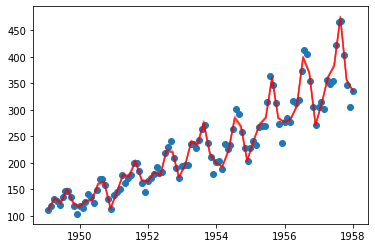

In [17]:
# Create a bunch of kernels
amplitude_ts = tfp.util.TransformedVariable(1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale_ts = tfp.util.TransformedVariable(55, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_ts = psd_kernels.ExponentiatedQuadratic(amplitude_ts, length_scale_ts)

amplitude_s = tfp.util.TransformedVariable(1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale_s = tfp.util.TransformedVariable(1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_s = tfp.math.psd_kernels.ExpSinSquared(amplitude_s, length_scale_s, period=1)

amplitude_t = tfp.util.TransformedVariable(2,tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale_t = tfp.util.TransformedVariable(60, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_t = psd_kernels.ExponentiatedQuadratic(amplitude_t, length_scale_t)

amplitude_ir = tfp.util.TransformedVariable(2,tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale_ir = tfp.util.TransformedVariable(50, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_ir = psd_kernels.RationalQuadratic(amplitude_ts, length_scale_ts)

amplitude_n = tfp.util.TransformedVariable(1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale_n = tfp.util.TransformedVariable(2, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_n = psd_kernels.ExponentiatedQuadratic(amplitude_n, length_scale_n)

kernel = kernel_s*kernel_ts + kernel_t + kernel_ir + kernel_n

observation_noise_variance = tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(kernel=kernel,index_points=xtrain,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(ytrain)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# Construct the posterior at a new set of `index_points` using the same kernel 
index_points = np.linspace(min(xtrain)[0], max(xtrain)[0], 50)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=xtrain,
    observations=ytrain,
    observation_noise_variance=observation_noise_variance)

# Train the model, draw, and plot posterior samples.
for i in range(2000):
  neg_log_likelihood_ = optimize()
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_s._value().numpy()))
print('length_scale: {}'.format(length_scale_s._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance._value().numpy()))

samples = gprm.sample(10).numpy()
plt.scatter(xtrain, ytrain)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)

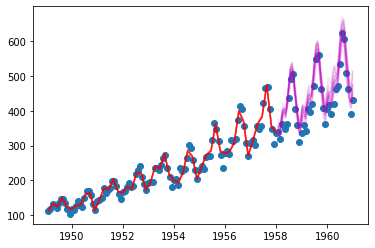

In [22]:
predictive_index_points_ = np.linspace(min(xtest)[0], max(xtest)[0], 50, dtype=np.float64)
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfp.math.psd_kernels.ExpSinSquared(amplitude_s, length_scale_s, period = 1) \
                  *tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude_ts, length_scale_ts)\
                  + tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude_t, length_scale_t)\
                  + tfp.math.psd_kernels.RationalQuadratic(amplitude_ir, length_scale_ir)\
                  + tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude_n, length_scale_n)

gprmp = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=xtrain,
    observations=ytrain,
    observation_noise_variance=observation_noise_variance,
    predictive_noise_variance=0.)

# Create 50 independent samples from the 300 created, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. 
num_samples = 20
samples_predict = gprmp.sample(num_samples)
plt.scatter(x, y)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples_predict[i, :], c='m', alpha=.1, label='Posterior Sample' if i == 0 else None)
  